# Imports

In [1]:
from utils import *
import os
SEED = 0
OUTPUT_FILE = 'results/kl_unif.csv'

if os.path.exists(OUTPUT_FILE):
    prev_results = pd.read_csv(OUTPUT_FILE)
    SEED = len(prev_results)
    print(f'Reanudando. {len(prev_results)} simulaciones previas')
else:
    print(f'Nueva corrida')

N_ITERS = 11

Reanudando. 100 simulaciones previas


In [2]:
prev_results.mean()

KL_p     0.112834
KL_f    92.840157
KL_w    78.933050
dtype: float64

# Parámetros

In [2]:
# FPCA
N_BASIS = 30
N_COMPONENTS = 2

# WGAN
N_EPOCHS = 2000
N_CRITIC = 5
LAMBDA_GP = 0.5
BATCH_SIZE = 128
LATENT_DIM = 1
CONDITION_DIM = 1
INPUT_DIM = 1
G_HIDDEN_LAYERS = 4
G_HIDDEN_DIM = 16
G_LEAKY_RELU = 0.1
D_HIDDEN_LAYERS = 2
D_HIDDEN_DIM = 64
D_DROPOUT = 0.4
D_LEAKY_RELU = 0.1
LR_GEN = 0.0002
LR_DIS = 0.0002
B1 = 0.5
B2 = 0.999

# Simulaciones

In [3]:
# Para generación de datos
VARS = ['var1']
T = 20
H_STEPS = 5
TIME_PERIODS = np.arange(T)
PREDICT_RANGE = range(T, T+H_STEPS)
N_SAMPLES = 1000

In [4]:
np.random.seed(SEED)
torch.manual_seed(SEED)

sigma = 1
offset = 10

KL_p = []
KL_f = []
KL_w = []

for n_iter in tqdm(range(N_ITERS)):
    # Genero observaciones hasta T
    #print(f'Step {n_iter+1}\nGenerating new samples\n')
    data = []

    for t in TIME_PERIODS:
        samples = np.random.normal(loc=t, scale=sigma, size=[N_SAMPLES,len(VARS)])
        samples = pd.DataFrame(samples, columns = VARS)
        samples['time'] = t
        data.append(samples)

    data = pd.concat(data, ignore_index=True)
    
    # Ajusto KDEs
   
    kdes = get_kdes(data, VARS[0], 'time', TIME_PERIODS)

    grid_points = np.linspace(data.var1.min()-offset, data.var1.max()+offset, N_SAMPLES)
    data_matrix = [kdes[t].score_samples(grid_points.reshape(-1,1)) for t in TIME_PERIODS]

    # Genero hasta H_STEPS
    true = []
    
    for t in PREDICT_RANGE:
        samples = np.random.normal(loc=t, scale=sigma, size=[N_SAMPLES, len(VARS)])
        samples = pd.DataFrame(samples, columns=VARS)
        samples['time'] = t
        true.append(samples)

    true = pd.concat(true, ignore_index=True)
    
    true_kdes = get_kdes(true, VARS[0], 'time', PREDICT_RANGE)

    true_data_matrix = [true_kdes[t].score_samples(grid_points.reshape(-1,1)) for t in PREDICT_RANGE]


    # PARAMETRICO
    #print('Ajustando paramétrico...')
    parameters = pd.DataFrame(
                  [norm.fit(data.loc[data.time == t, 'var1']) for t in TIME_PERIODS],
                  columns = ['mu','sigma']
                  )
    
    fit_mean = FitData('lin')
    fit_mean.fit(TIME_PERIODS, parameters.mu)
    
    pred = pd.DataFrame(
      {
          'mu': fit_mean.predict(H_STEPS),
          'sigma': parameters['sigma'].mean(),
          't': range(T,T+H_STEPS)
      }
    )

    preds = [norm.pdf(grid_points, loc=row.mu, scale=row.sigma) for _,row in pred.iterrows()]
    
    kls_p = [get_kl( preds[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
    kl_p = np.mean(kls_p)
    KL_p.append(kl_p)
    
    #print(f'Done. KL: {kl_p}\n')
    
    # FPCA
    #print('Ajustando fPCA...')
    fpca_1n = Fpca(data_matrix, grid_points, n_basis=N_BASIS)
    fpca_1n.fit_fpca(n_components=N_COMPONENTS)
    
    models = {}

    # Lin y poly 2
    
    models[0] = FitData('lin')
    models[0].fit(TIME_PERIODS, fpca_1n.scores[:,0])
    
    models[1] = FitData('poly', degree=2)
    models[1].fit(TIME_PERIODS, fpca_1n.scores[:,1])

    fpca_1n.fit_time_series(models=models, h_steps=H_STEPS)
    
    fpca_1n.predict(exp=True, normalize=True)
    
    kls_f = [get_kl( fpca_1n.pred_f[i][1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
    kl_f = np.mean(kls_f)
    KL_f.append(kl_f)
    
    #print(f'Done. KL: {kl_f}\n')
    
    # WGAN
    # print('Ajustando WGAN...')
    wgan_1n = Wgan(data = data,
                vars = VARS,
                latent_dim = LATENT_DIM,
                condition_dim = CONDITION_DIM,
                g_hidden_layers = G_HIDDEN_LAYERS,
                g_hidden_dim = G_HIDDEN_DIM,
                g_leaky_relu = G_LEAKY_RELU,
                d_hidden_layers = D_HIDDEN_LAYERS,
                d_hidden_dim = D_HIDDEN_DIM,
                d_dropout = D_DROPOUT,
                d_leaky_relu = D_LEAKY_RELU,
                input_dim = INPUT_DIM,
                lr_gen = LR_GEN,
                lr_dis = LR_DIS,
                b1 = B1,
                b2 = B2,
                lambda_gp = LAMBDA_GP,
                n_critic = N_CRITIC,
                batch_size = BATCH_SIZE,
                device = DEVICE)

    wgan_1n.train(n_epochs=N_EPOCHS, trace=False)
    
    new_obs = wgan_1n.sample(time_periods=PREDICT_RANGE, sample_size=N_SAMPLES)
    kde_forecasts = get_kdes(new_obs, VARS[0], 'time', PREDICT_RANGE)
    
    output_wgan = [kde_forecasts[i].score_samples(grid_points.reshape(-1,1)) for i in PREDICT_RANGE]
    
    kls_w = [get_kl( np.exp(output_wgan[i])[1:-1], np.exp(true_data_matrix[i])[1:-1] ) for i in range(H_STEPS)]
    kl_w = np.mean(kls_w)
    KL_w.append(kl_w)
    
    #print(f'Done. KL: {kl_w}\n')

100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [7:37:42<00:00, 2496.62s/it]


# Sanity Checks

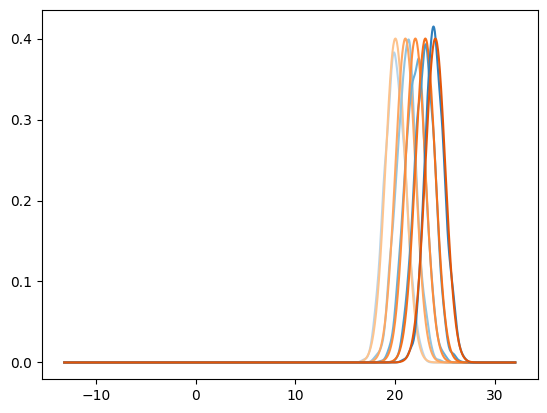

In [5]:
for c, i in zip(np.linspace(0.3,0.7,H_STEPS), range(H_STEPS)):
    plt.plot(grid_points, np.exp(true_data_matrix[i]), color=BLUE(c))
    plt.plot(grid_points, preds[i], color=ORANGE(c))

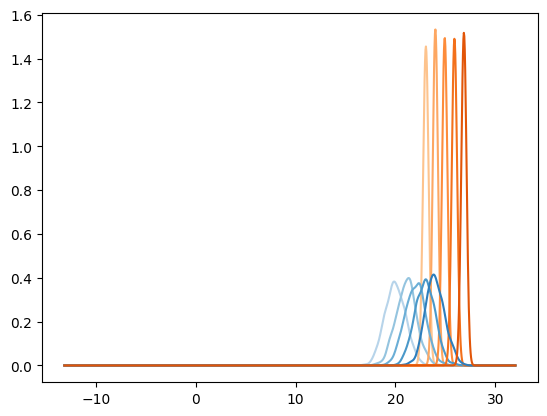

In [6]:
for c, i in zip(np.linspace(0.3,0.7,H_STEPS), range(H_STEPS)):
    plt.plot(grid_points, np.exp(true_data_matrix[i]), color=BLUE(c))
    plt.plot(grid_points, fpca_1n.pred_f[i], color=ORANGE(c))

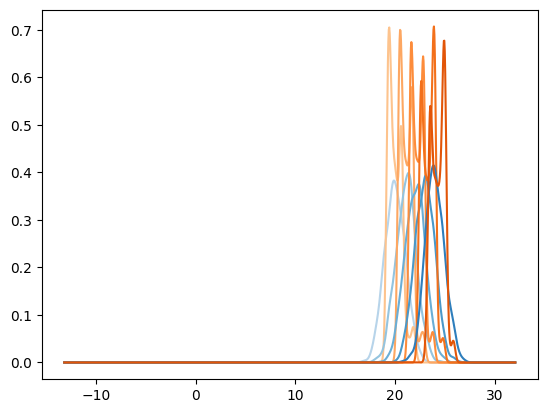

In [7]:
for c, i in zip(np.linspace(0.3,0.7,H_STEPS), range(H_STEPS)):
    plt.plot(grid_points, np.exp(true_data_matrix[i]), color=BLUE(c))
    plt.plot(grid_points, np.exp(output_wgan[i]), color=ORANGE(c))

# Resultados

In [8]:
results = pd.DataFrame({
                'KL_p': KL_p,
                'KL_f': KL_f,
                'KL_w': KL_w
            })

In [9]:
print(f'KLs de esta corrida:\n{results.mean()}\n')

if os.path.exists(OUTPUT_FILE):
    results = pd.concat([prev_results, results], ignore_index=True)
    print(f'KLs hasta ahora:\n{results.mean()}\n')
    
results.to_csv(OUTPUT_FILE, index=False)

KLs de esta corrida:
KL_p      0.111324
KL_f    105.705945
KL_w     69.009119
dtype: float64

KLs hasta ahora:
KL_p     0.112834
KL_f    92.840157
KL_w    78.933050
dtype: float64



# Fin